# Optimization

## Linear optimization

Let's consider the following optimization problem:

\begin{align}
  \text{minimize} & 12x + 20y \\
  \text{subject to} & \\
  & 7x + 12y \geq 120 \\
  & x \geq 0 \\
  & y \in [0,3].
\end{align}

This can be solved using the package `JuMP` and the solver `HiGHS`.

In [1]:
using JuMP
using HiGHS

We initialize the model as follows:

In [2]:
model = Model(HiGHS.Optimizer)

A JuMP Model
├ solver: HiGHS
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 0
├ num_constraints: 0
└ Names registered in the model: none

The variables can be defined as follows:

In [3]:
@variable(model, x >= 0)
@variable(model, 0 <= y <= 3)

y

Then we can define the objective function.

In [4]:
@objective(model, Min, 12x + 20y)

12 x + 20 y

Let's add the restrictions.

In [5]:
@constraint(model, c1, 6x + 8y >= 100)
@constraint(model, c2, 7x + 12y >= 120)

c2 : 7 x + 12 y ≥ 120

Let's print the model definition.

In [6]:
print(model)

Min 12 x + 20 y
Subject to
 c1 : 6 x + 8 y ≥ 100
 c2 : 7 x + 12 y ≥ 120
 x ≥ 0
 y ≥ 0
 y ≤ 3


Let's optimize.

In [7]:
optimize!(model)

Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
LP   has 2 rows; 2 cols; 4 nonzeros
Coefficient ranges:
  Matrix [6e+00, 1e+01]
  Cost   [1e+01, 2e+01]
  Bound  [3e+00, 3e+00]
  RHS    [1e+02, 1e+02]
Presolving model
2 rows, 2 cols, 4 nonzeros  0s
2 rows, 2 cols, 4 nonzeros  0s
Presolve : Reductions: rows 2(-0); columns 2(-0); elements 4(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 2(220) 0s
          2     2.0500000000e+02 Pr: 0(0) 0s
Model status        : Optimal
Simplex   iterations: 2
Objective value     :  2.0500000000e+02
P-D objective error :  6.9152577690e-17
HiGHS run time      :          0.01


Show the results.

In [8]:
@show objective_value(model)
@show value(x)
@show value(y)

objective_value(model) = 204.99999999999997
value(x) = 15.000000000000005
value(y) = 1.249999999999996


1.249999999999996

## Non-linear optimization

### Univariate non-linear optimization

In [9]:
using Optim
using CairoMakie

The function to be optimized should have an array as input.

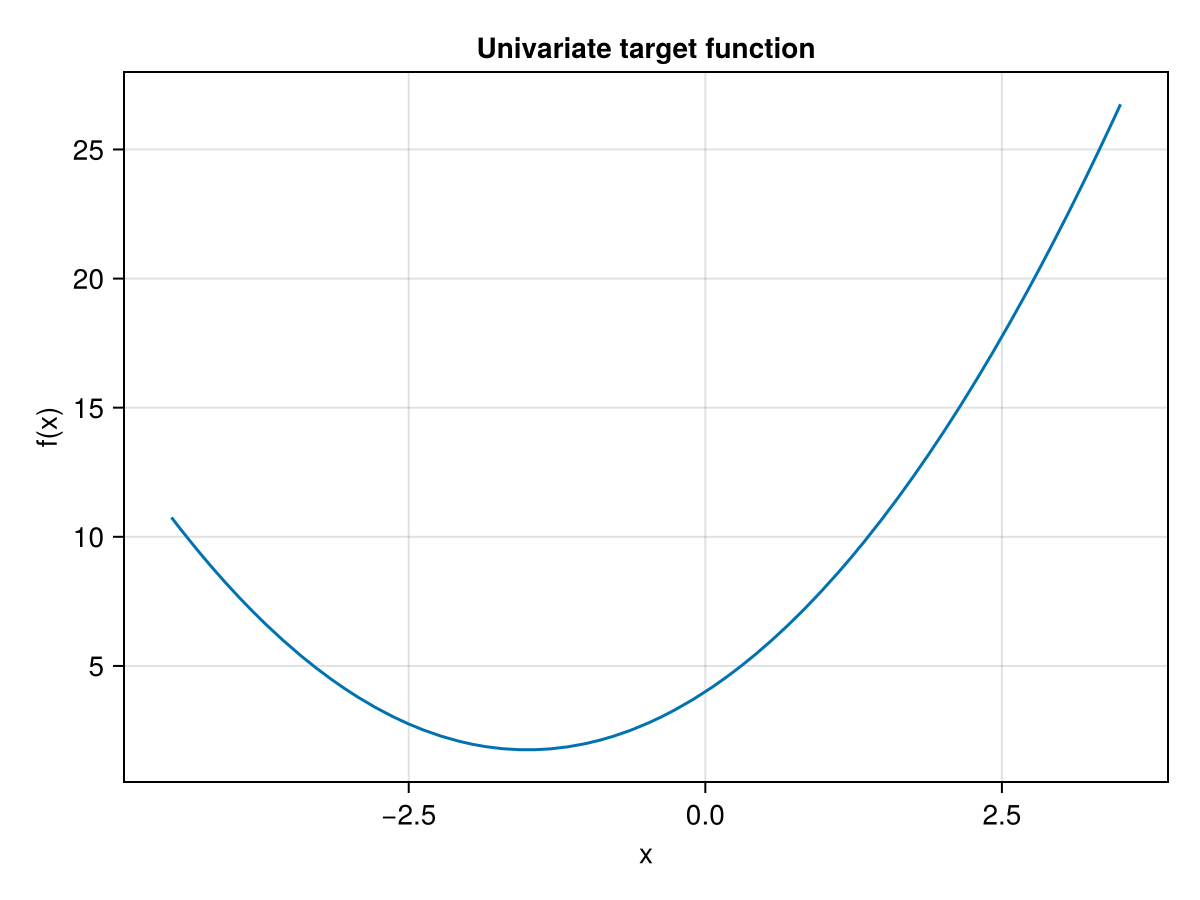

In [10]:
f(x) = x[1]^2 + 3x[1] + 4
axis_args = (title = "Univariate target function", xlabel = "x", ylabel = "f(x)")
fig = lines(-4.5..3.5, f, axis = axis_args)

The function `optimize` can be used to perform optimization.

In [11]:
out = optimize(f, [4.0])
x0 = Optim.minimizer(out)

1-element Vector{Float64}:
 -1.4999996185302742

In [12]:
fig = lines(-4.5..3.5, f, axis = axis_args)
scatter!(x0, [f(x0)], color = :red)

Makie.Scatter{Tuple{Vector{GeometryBasics.Point{2, Float64}}}}

### Multivariate  non-linear optimization

In [13]:
f(x) = (1.0 - x[1])^2 + 100.0 * (x[2] - x[1]^2)^2
x1 = -2:0.03:3
x2 = -2:0.03:2
grid = [[i, j] for i in x1 for j in x2]
y = f.(grid)

22378-element Vector{Float64}:
 3609.0
 3573.0899999999997
 3537.359999999999
 3501.81
 3466.4399999999996
 3431.2499999999995
 3396.2400000000007
 3361.41
 3326.7599999999998
 3292.2900000000004
    ⋮
 5088.180816
 5045.488415999999
 5002.976015999999
 4960.643616
 4918.491215999999
 4876.518816
 4834.726416
 4793.114016
 4751.681615999999

In [14]:
fig = Figure()
ax = Axis(fig[1,1], title = "log(f(x))", xlabel = "x[1]", ylabel = "x[2]")
hm = heatmap!(x1, x2, reshape(log.(y), length(x2), length(x1))')
Colorbar(fig[1,2], hm)

Makie.Colorbar()

Similarly to the univariate case, we use the function `optimize`.

In [15]:
x0 = [0.0, 0.0]
out = optimize(f, x0)
Optim.minimizer(out)

2-element Vector{Float64}:
 0.9999634355313174
 0.9999315506115275

We can compute the gradient and Hessian of this function to apply other optimization
algorithms.

In [16]:
function g!(G, x)
    G[1] = -2.0 * (1.0 - x[1]) - 400.0 * (x[2] - x[1]^2) * x[1]
    G[2] = 200.0 * (x[2] - x[1]^2)
end

function h!(H, x)
    H[1, 1] = 2.0 - 400.0 * x[2] + 1200.0 * x[1]^2
    H[1, 2] = -400.0 * x[1]
    H[2, 1] = -400.0 * x[1]
    H[2, 2] = 200.0
end

h! (generic function with 1 method)

#### Newton's method

We can apply the Newton's method providing the gradient and Hessian functions.

In [17]:
initial_x = zeros(2)
out1 = optimize(f, g!, h!, initial_x, Newton())
Optim.minimizer(out1)

2-element Vector{Float64}:
 0.9999999999999994
 0.9999999999999989

In case we do not have the gradient and Hessian functions, we can use *auto
differentiation*.

In [18]:
out2 = optimize(f, initial_x, Newton(); autodiff = :forward)
Optim.minimizer(out2)

2-element Vector{Float64}:
 0.9999999999999994
 0.9999999999999989

#### Gradient descent

For the gradient descent algorithm, we only need to provide the gradient function.

In [19]:
res = optimize(f, g!, [0.0, 0.0], GradientDescent(),
    Optim.Options(g_tol = 1e-4, iterations = 10000)
)
Optim.minimizer(res)

2-element Vector{Float64}:
 0.9999143322638654
 0.9998281725940559

We can also *auto differentiation*.

In [20]:
res = optimize(f, [0.0, 0.0], GradientDescent(),
    Optim.Options(g_tol = 1e-4, iterations = 10000);
    autodiff = :forward,
)
Optim.minimizer(res)

2-element Vector{Float64}:
 0.9999143329171802
 0.9998281739063749

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*